<a href="https://colab.research.google.com/github/Mayankjain0807/Machine_learning_projects/blob/Machine-Learning-Projects/Sentiment_analysis_of_Threads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,precision_score,recall_score, f1_score, roc_auc_score
from textblob import TextBlob, Word
import nltk
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
import seaborn as  sns
import matplotlib.pyplot as plt
import regex as re
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from google.colab import files
spam = files.upload()

Saving threads_reviews.csv to threads_reviews.csv


In [3]:
import io
data = pd.read_csv(io.BytesIO(spam['threads_reviews.csv']))

In [4]:
# Lets see the overview of our dataset
data.head()

,source,review_description,rating,review_date
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24
1,Google Play,Pretty good for a first launch!! Its easy to u...,3,2023-07-19 20:52:48
2,Google Play,"For a brand new app, it's very well optimized....",3,2023-07-06 23:03:11
3,Google Play,"Great app with a lot of potential! However, th...",3,2023-07-10 00:53:25
4,Google Play,"The app is good, but it needs a lot of functio...",3,2023-07-06 16:57:43


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32910 entries, 0 to 32909
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   source              32910 non-null  object
 1   review_description  32910 non-null  object
 2   rating              32910 non-null  int64 
 3   review_date         32910 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


#**Null values**

In [8]:
data.isnull().sum()

source                0
review_description    0
rating                0
review_date           0
dtype: int64

In [9]:
# Make a copy of our dataset
df = data.copy()

#**EDA**

# **1-REVIEW SOURCE**

Text(0.5, 1.0, 'Source')

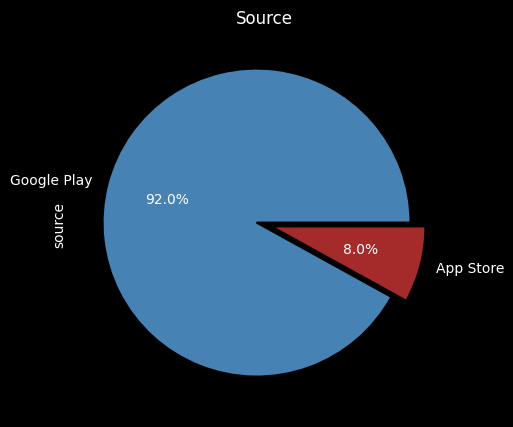

In [37]:
# SOURCE OF REVIEW

plt.figure(figsize=(6,5))
df['source'].value_counts().plot(kind='pie', autopct='%1.1f%%',wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1.5,'antialiased': True},colors=['steelblue', 'brown'],explode = (0.05,0.05))
plt.title('Source')

# **2-Rating of Threads**

Text(0.5, 1.0, 'Ratings of Threads')

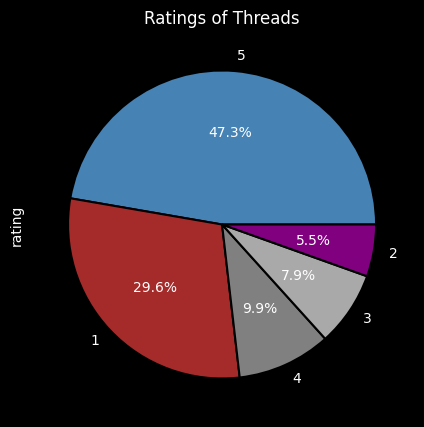

In [126]:
plt.figure(figsize=(6,5))
df['rating'].value_counts().plot(kind='pie',autopct='%1.1f%%',wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1.5,'antialiased': True},colors=['steelblue', 'brown','grey','darkgrey','purple'])

plt.title('Ratings of Threads')

### **The percentage of rating 5 is 47.3% and rating 1 is 29.6%. Weitage of rating 2,3,4 is 5.5%,7.9%,9.9% respectively**


# **3-Rating of Threads on Different Source**

Text(0.5, 1.0, 'Rating of Threads on Different Source')

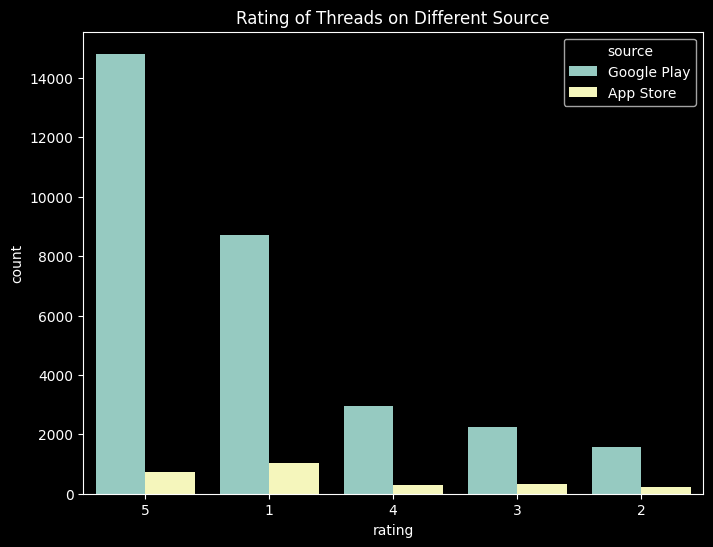

In [41]:
plt.style.use('dark_background')
plt.figure(figsize = (8, 6))
sns.countplot(data = df, x = 'rating', hue = 'source', order = df['rating'].value_counts(ascending=False).index)
plt.title("Rating of Threads on Different Source")

# **SENTIMENT ANALYSIS**

In [43]:
def cleaned_text(text):
  # Remove special characters and make it lower case
  text = re.sub(r'[^a-zA-ZÀ-ú\s]', '', text.lower())

  #Tokenization
  tokens=text.split()

  # Remove numbers
  tokens = [token for token in tokens if not token.isdigit()]

  # Remove punctuation
  tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]

  # Remove extra whitespace
  tokens = [token.strip() for token in tokens]

  # Remove two letter words
  tokens = [token for token in tokens if len(token) > 2]

  # Join the tokens back into a single text
  cleaned_text = ' '.join(tokens)
  return cleaned_text


In [45]:
df['new_review'] = [cleaned_text(text) for text in df['review_description']]
df.head()

,source,review_description,rating,review_date,new_review
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24,meh not the greatest experience chromebook see...
1,Google Play,Pretty good for a first launch!! Its easy to u...,3,2023-07-19 20:52:48,pretty good for first launch its easy use and ...
2,Google Play,"For a brand new app, it's very well optimized....",3,2023-07-06 23:03:11,for brand new app its very well optimized howe...
3,Google Play,"Great app with a lot of potential! However, th...",3,2023-07-10 00:53:25,great app with lot potential however there lot...
4,Google Play,"The app is good, but it needs a lot of functio...",3,2023-07-06 16:57:43,the app good but needs lot functionality for e...


# **Tokenization and Removal of stop words**

In [46]:
# Tokenization
df['new_review'] = df['new_review'].apply(word_tokenize)
# Removing stopwords
stop_words = set(stopwords.words('english'))
df['new_review'] = df['new_review'].apply(lambda x: [word for word in x if word not in stop_words])

In [52]:
df.head()

,source,review_description,rating,review_date,new_review
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24,meh greatest experience chromebook seems custo...
1,Google Play,Pretty good for a first launch!! Its easy to u...,3,2023-07-19 20:52:48,pretty good first launch easy use selfexplanat...
2,Google Play,"For a brand new app, it's very well optimized....",3,2023-07-06 23:03:11,brand new app well optimized however missing q...
3,Google Play,"Great app with a lot of potential! However, th...",3,2023-07-10 00:53:25,great app lot potential however lot need fixed...
4,Google Play,"The app is good, but it needs a lot of functio...",3,2023-07-06 16:57:43,app good need lot functionality example search...


# **Lemmatization**

In [49]:
lemmatizer = WordNetLemmatizer()
df['new_review'] = df['new_review'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [51]:
# Joining the words back into a single text
df['new_review'] = df['new_review'].apply(lambda x: ' '.join(x))

In [53]:
df.head()

,source,review_description,rating,review_date,new_review
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24,meh greatest experience chromebook seems custo...
1,Google Play,Pretty good for a first launch!! Its easy to u...,3,2023-07-19 20:52:48,pretty good first launch easy use selfexplanat...
2,Google Play,"For a brand new app, it's very well optimized....",3,2023-07-06 23:03:11,brand new app well optimized however missing q...
3,Google Play,"Great app with a lot of potential! However, th...",3,2023-07-10 00:53:25,great app lot potential however lot need fixed...
4,Google Play,"The app is good, but it needs a lot of functio...",3,2023-07-06 16:57:43,app good need lot functionality example search...


# **TOP 10 Most Used words**

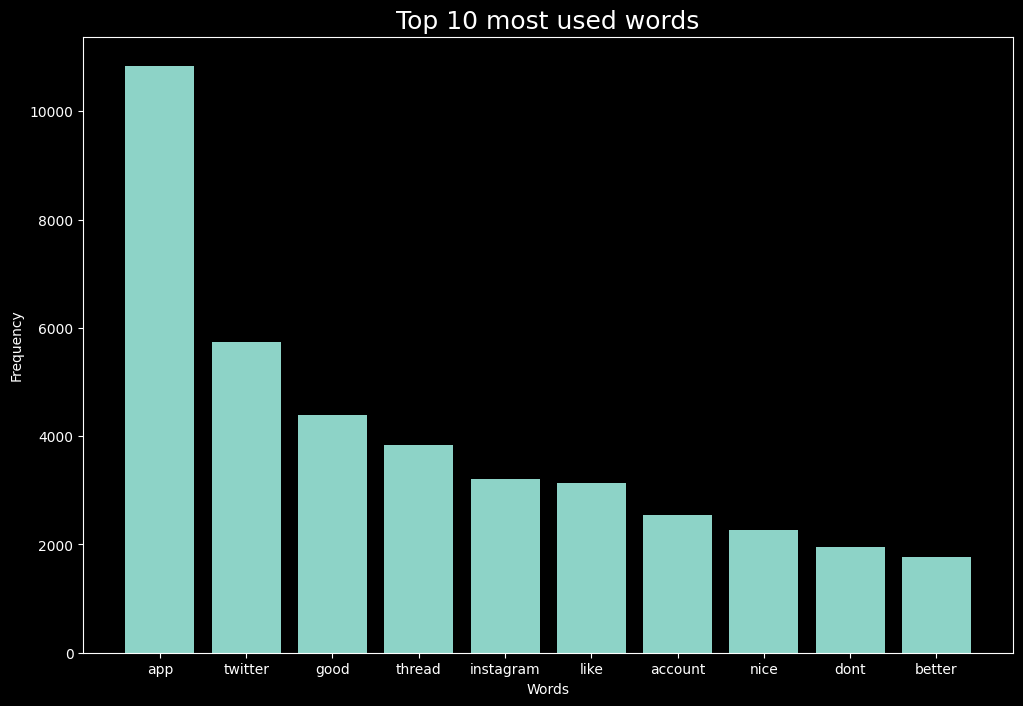

In [55]:
import collections

words = []
for text in df['new_review']:
    words.extend(text.split())
# print(words)

word_count = collections.Counter(words)
# print(word_count)

# Top 10 words
top_words = dict(word_count.most_common(10))

# Dark Background and figure size
# plt.style.use('dark_background')
plt.figure(figsize = (12, 8))

# Create the Barplot
plt.bar(list(top_words.keys()), list(top_words.values()), align = 'center')

# Grid Opacity
# plt.grid(alpha = 0.5)

# Title
plt.title('Top 10 most used words', fontsize = 18)

# Labels
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.show()

# **Most common words in our dataset**

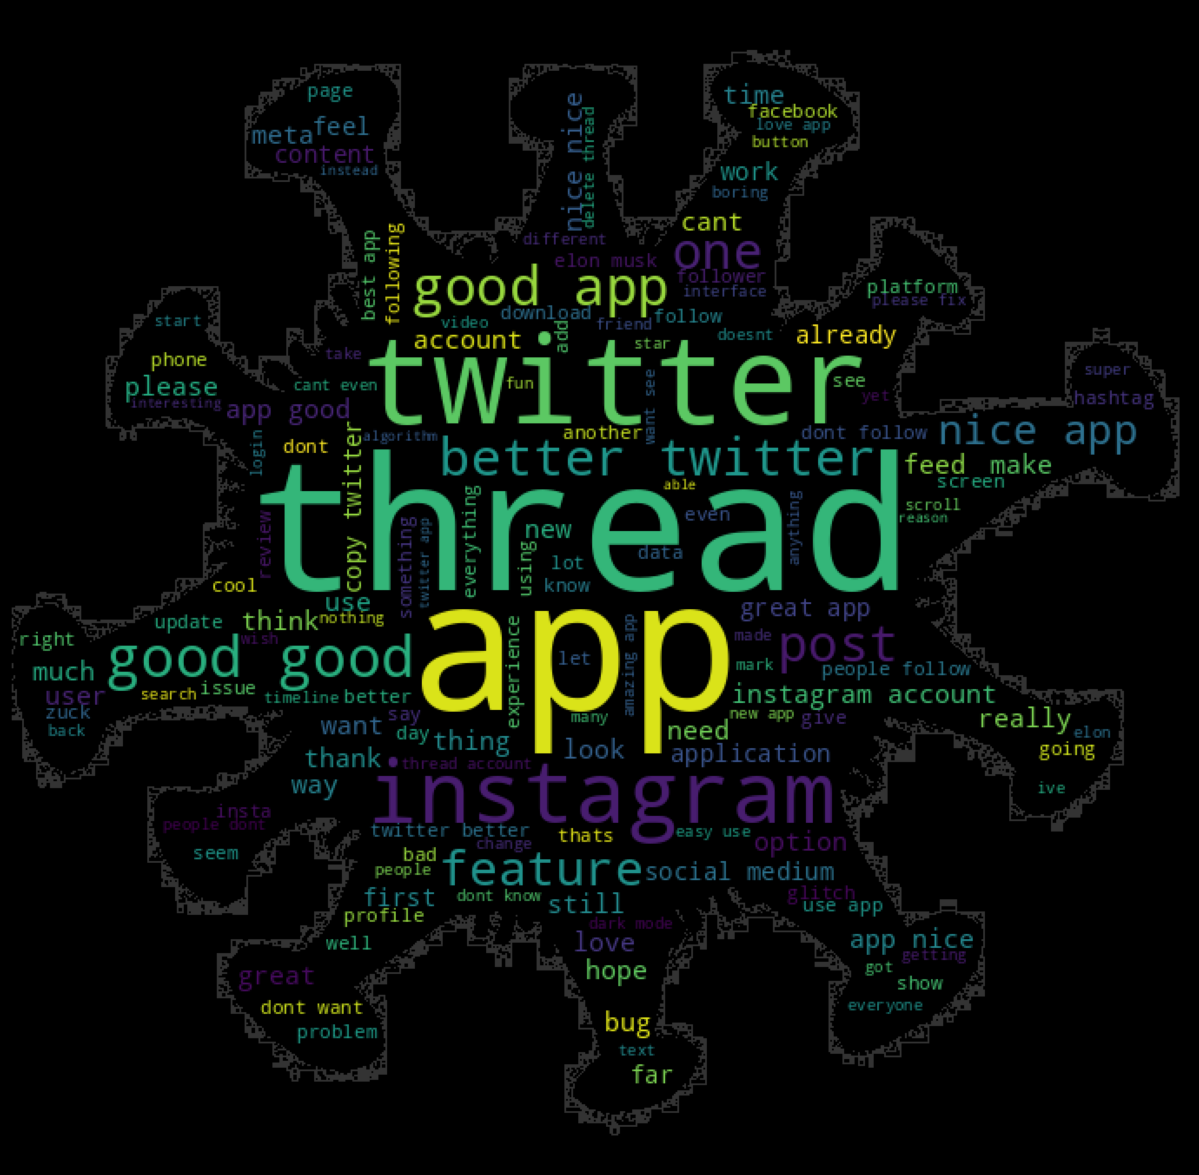

In [57]:
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image
import requests
import io
response = requests.get("https://res.cloudinary.com/maxie/image/upload/v1617197755/TEMP/covid_ywd7ph.jpg")
image_bytes = io.BytesIO(response. content)
dataset = " ".join(df.new_review.loc[:])
def create_word_cloud(string):

    maskArray = np.array(Image.open(image_bytes))
    cloud = WordCloud(background_color = "black", max_words = 150, mask = maskArray, stopwords = set(STOPWORDS),contour_width=1, contour_color='#333')
    cloud.generate(string)
#     cloud.to_file("wordCloud.png")
    return cloud
dataset = dataset.lower()
wordcloud=create_word_cloud(dataset)
plt.figure(figsize=[20,15])
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.show()

# **Words with Rating 5 and Rating 1**

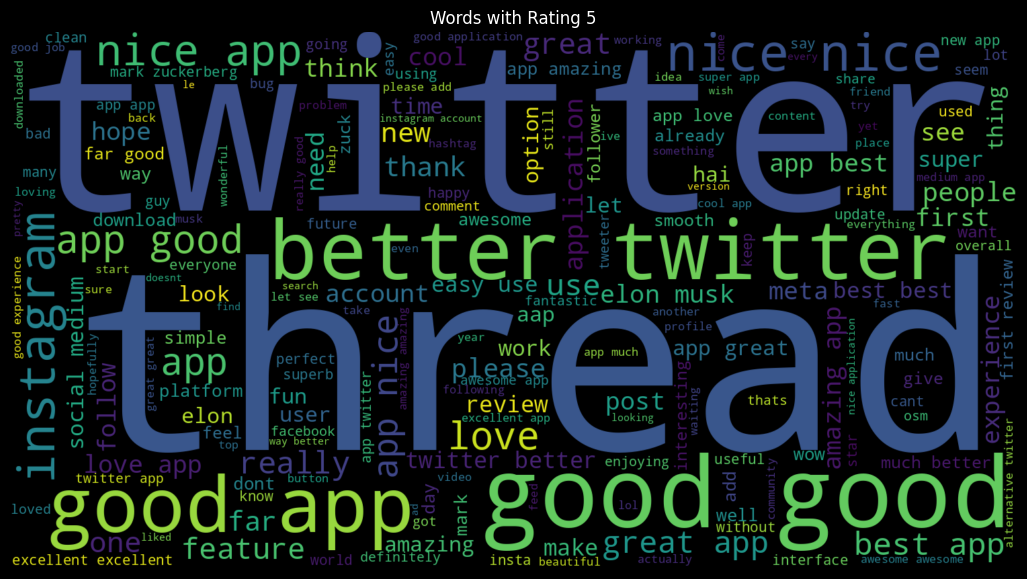

In [62]:
# Most of the ratings are fall either 5 or 1, so let's see the 5 star rating words and 1 star rating words.
text = ' '.join(df.loc[df["rating"]== 5]["new_review"].apply(lambda x: "".join(x)))
wordcloud = WordCloud(height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)

plt.figure(figsize=(13, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Words with Rating 5')
plt.show()

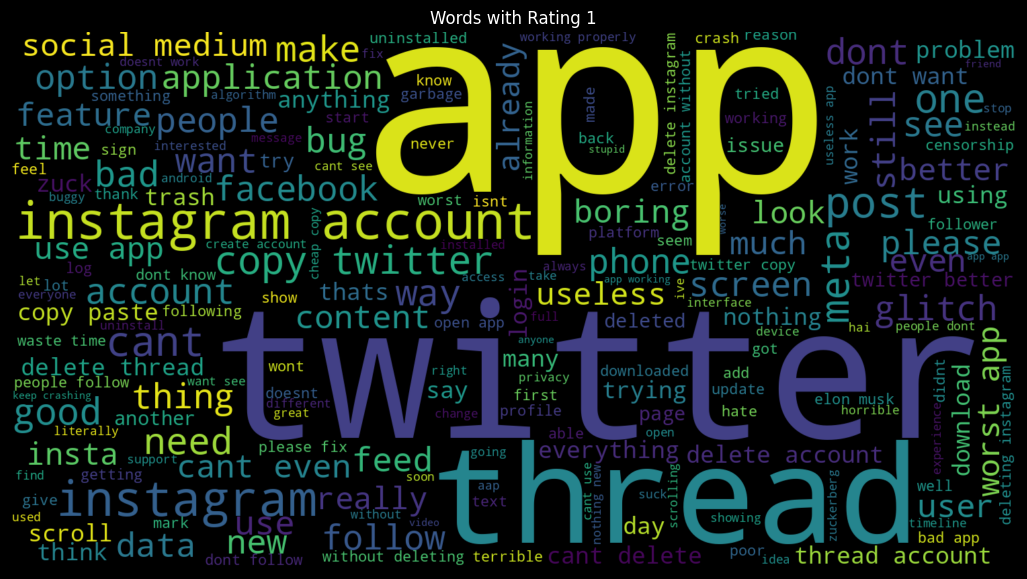

In [63]:
text = ' '.join(df.loc[df["rating"]== 1]["new_review"].apply(lambda x: "".join(x)))
wordcloud = WordCloud(height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)

plt.figure(figsize=(13, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Words with Rating 1')
plt.show()

In [64]:
pip install textblob

#**Sentiment analyse with the use of TextBlob**

In [68]:
from textblob import TextBlob

def sentiment(text):
  blob = TextBlob(text)

  sentiment_polarity = blob.sentiment.polarity
  sentiment_subjectivity = blob.sentiment.subjectivity

  if sentiment_polarity > 0:
    return 'Positive'

  elif sentiment_polarity < 0:
    return 'Negative'
  else:
    return 'Neutral'

In [69]:
df['sentiment'] = df['new_review'].apply(sentiment)

In [101]:
# calculate the percentage of sentiment

print('The percentage of Positive sentiment is:',round(len(df[df['sentiment']== 'Positive'])/len(df)*100,1))
print('The percentage of Neutral sentiment is:',round(len(df[df['sentiment']== 'Neutral'])/len(df)*100,1))
print('The percentage of Negative sentiment is:',round(len(df[df['sentiment']== 'Negative'])/len(df)*100,1))

The percentage of Positive sentiment is: 52.2
The percentage of Neutral sentiment is: 35.7
The percentage of Negative sentiment is: 12.1


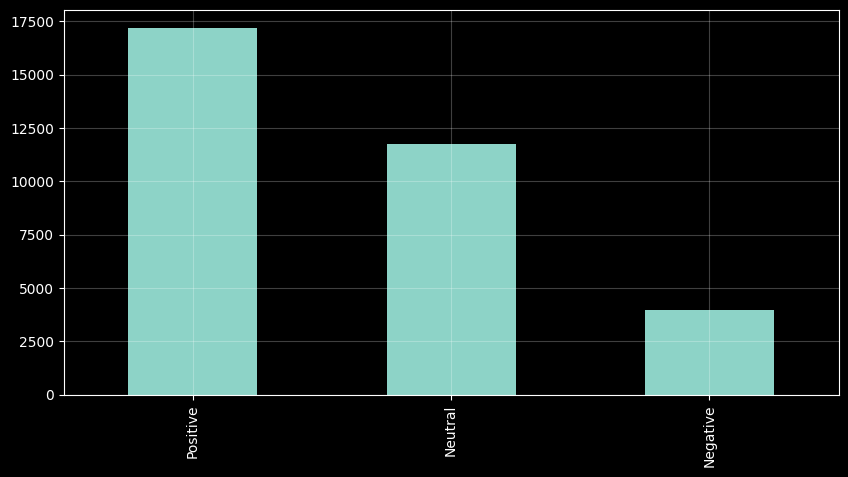

In [112]:
# plot the graph of sentiment
plt.figure(figsize=(10,5))
df.sentiment.value_counts().plot(kind = 'bar')
# Grid Opacity
plt.grid(alpha = 0.25)

# **Overall sentiment for THREAD App showing Positive. 52% are Positive sentiments, 35.7% are Neutral and 12% are Negative**